## Data Preparation

In [ ]:
from IPython.display import Markdown, display
from matplotlib import pyplot as plt 

import cv2
from src.utility import plot_value_counts
import data_preparation as dp

CELEBA_DIR = 'CelebA_Spoof/'

# Spoof атаки, которые оставляем
spoof_filter = [0, 1, 2, 3, 7, 8, 9]

Train / Test shape
          original: (494405, 44) / (67170, 44)
          filtered: (356690, 44) / (49646, 44)


#### Train set Spoof labels

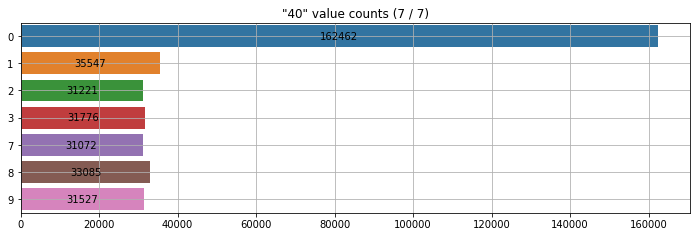

#### Test set Spoof labels

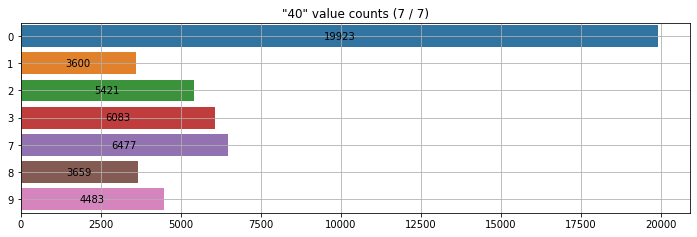

In [24]:
train_label, test_label = dp.read_orig_labels(CELEBA_DIR, spoof_filter)

display(Markdown('#### Train set Spoof labels'))
plot_value_counts(train_label[40], sort_index=True)
display(Markdown('#### Test set Spoof labels'))
plot_value_counts(test_label[40], sort_index=True)

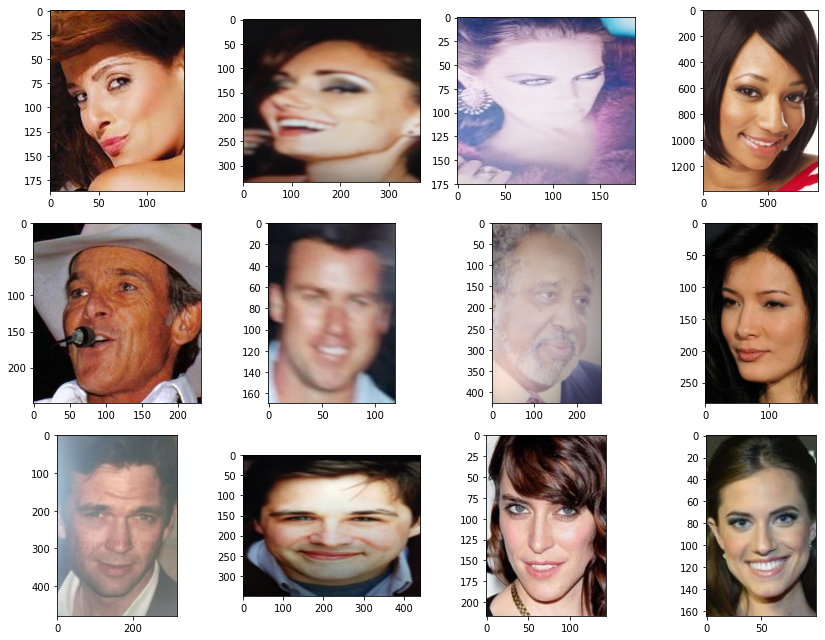

In [26]:
fig = plt.figure(figsize=(12,9))
for i in range(12):
    fig.add_subplot(3, 4, i+1)
    img = dp.read_image('/'.join([CELEBA_DIR, train_label.index[i]]))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.tight_layout()
plt.show()

In [4]:
del train_label, test_label

## Сlass balance

#### Binary classification: Live / Spoof

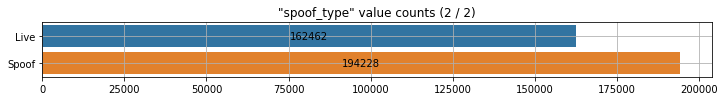

#### Live / Print attack / Replay attack

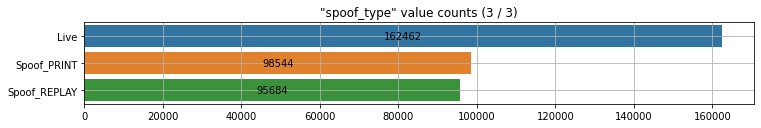

In [5]:
import pandas as pd
from config import TrainConfig

cnf = TrainConfig()
train_labels = pd.read_csv(cnf.labels_path)

def live_spoof(v):
    return 'Live' if v == 0 else 'Spoof'

def live_print_replay(v):
    if v in [1,2,3]:
        return 'Spoof_PRINT'
    if v in [7,8,9]:
        return 'Spoof_REPLAY'
    if v == 0:
        return 'Live'
    return 'other'

display(Markdown('#### Binary classification: Live / Spoof'))
spoofs = train_labels['spoof_type'].apply(lambda s: live_spoof(s))
plot_value_counts(spoofs, sort_index=True)

display(Markdown('#### Live / Print attack / Replay attack'))
spoofs = train_labels['spoof_type'].apply(lambda s: live_print_replay(s))
plot_value_counts(spoofs, sort_index=True)

## Testing data loader

In [1]:
import pandas as pd
from src.config import TrainConfig
from src.utility import plot_iter_images
from src.dataset_loader import get_train_valid_loader

In [3]:
cat = [[0],[1,2,3],[7,8,9]]
cnf = TrainConfig(spoof_categories=cat)
train_labels = pd.read_csv(cnf.labels_path)
spoof_transform = lambda t: next(i for i, l in enumerate(cat) if t in l)
train_labels.iloc[:,1] = train_labels.iloc[:,1].apply(spoof_transform)
value_counts = train_labels.iloc[:,1].value_counts()
train_downsampled = [train_labels[train_labels.iloc[:,1]==value_counts.index[-1]]]
for value in value_counts.index[:-1]:
    train_downsampled.append(
        train_labels[train_labels.iloc[:,1]==value].sample(
            value_counts.min()))
train_labels = pd.concat(train_downsampled)
train_labels.iloc[:,1].value_counts()

2    95684
0    95684
1    95684
Name: spoof_type, dtype: int64

Training loader batch


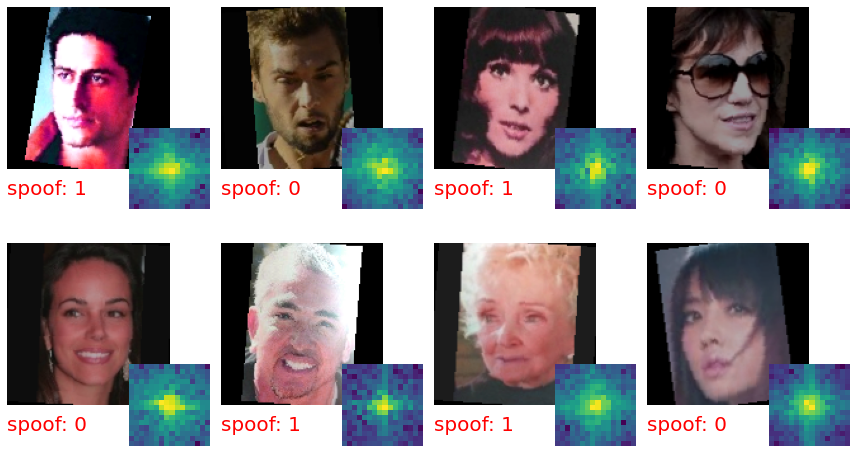

Valitation loader batch


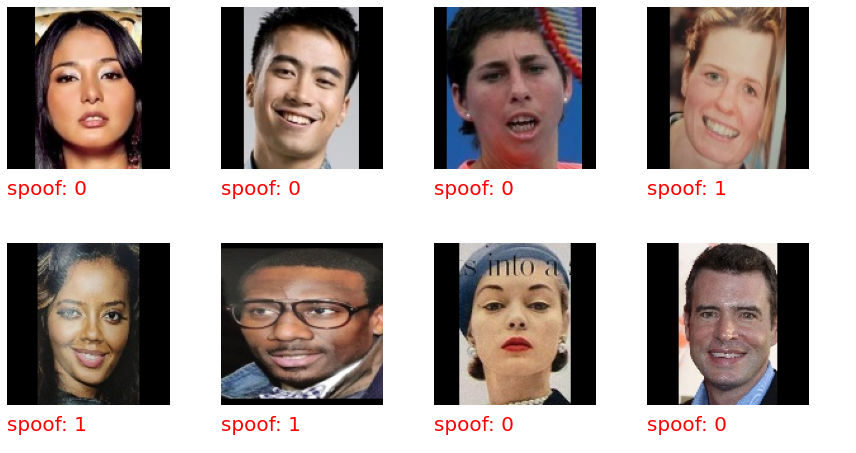

In [4]:
cnf = TrainConfig(spoof_categories='binary', batch_size=8)
train_loader, valid_loader = get_train_valid_loader(cnf)

plot_iter_images(iter(train_loader).next(), cnf.input_size, cnf.batch_size)
plot_iter_images(iter(valid_loader).next(), cnf.input_size, cnf.batch_size)

Training loader batch


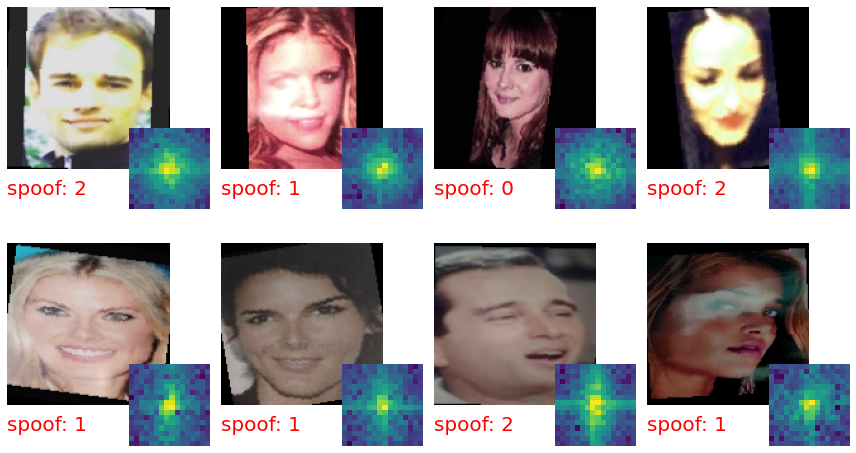

Valitation loader batch


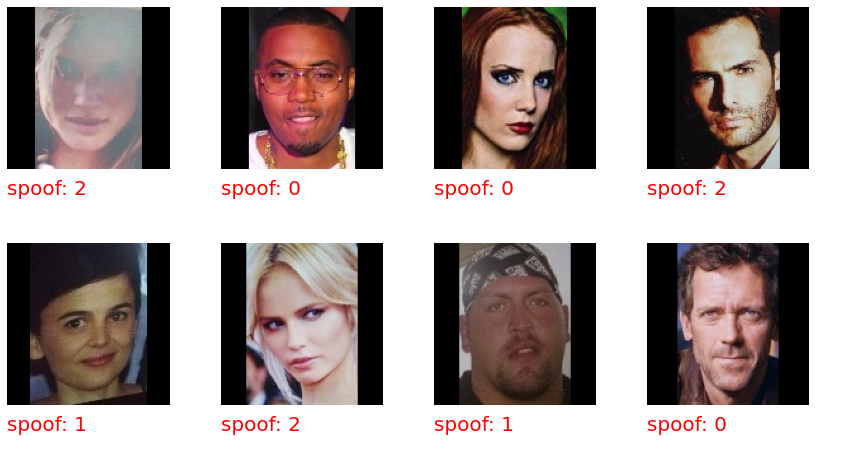

In [5]:
cnf = TrainConfig(spoof_categories=[[0],[1,2,3],[7,8,9]],
                  class_balancing='down', batch_size = 8)

train_loader, valid_loader = get_train_valid_loader(cnf)

plot_iter_images(iter(train_loader).next(), cnf.input_size, cnf.batch_size)
plot_iter_images(iter(valid_loader).next(), cnf.input_size, cnf.batch_size)

## Testing Model

In [ ]:
from src.config import TestConfig 
from src.antispoof_predict import AntiSpoofPredict
from tqdm.notebook import tqdm_notebook as tqdm
from src.dataset_loader import get_test_loader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (auc, roc_auc_score, accuracy_score, confusion_matrix,
                             precision_score, recall_score, f1_score)
from src.utility import (roc_curve_plots, confusion_matricies_plots, 
                         multiclass_roc_curve_plots)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

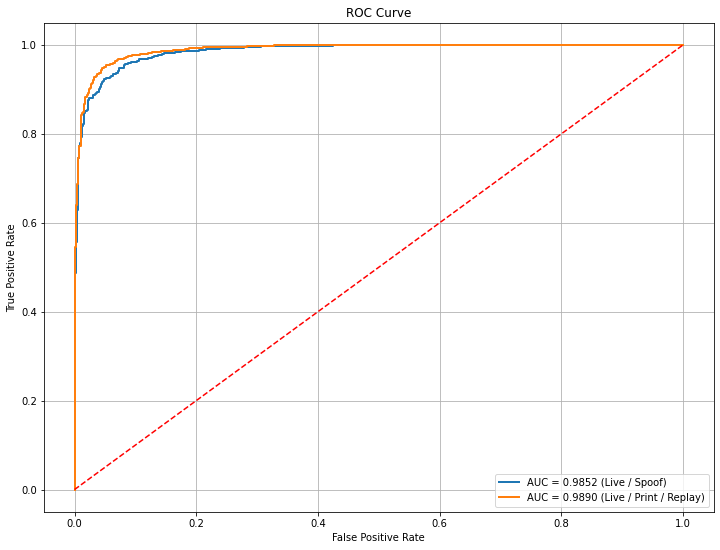

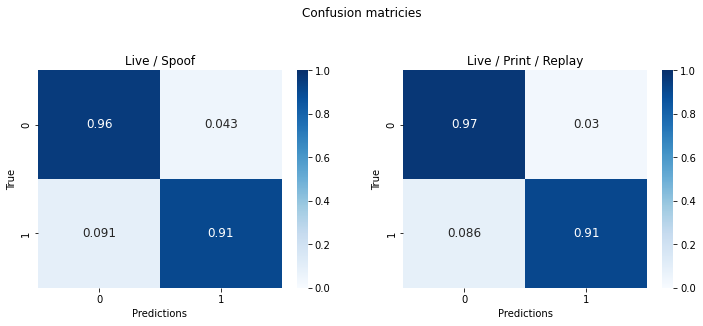

,Accuracy,AUC-ROC,Precision,Recall,F1 score
Live / Spoof,0.9284,0.985242,0.968436,0.909091,0.937826
Live / Print / Replay,0.9368,0.988995,0.978371,0.913805,0.944986


In [3]:
batches, batch_size = 5, 500
cnf_bin = TestConfig(
    batch_size=batch_size, spoof_categories='binary',
    model_path='saved_models/AntiSpoofing_bin_128.pth')
cnf_lpr = TestConfig(
    batch_size=batch_size, spoof_categories=[[0],[1,2,3],[7,8,9]],
    model_path='saved_models/AntiSpoofing_print-replay_128.pth')
models_loaders = {
    'Live / Spoof': (AntiSpoofPredict(cnf_bin), get_test_loader(cnf_bin)), 
    'Live / Print / Replay' : (AntiSpoofPredict(cnf_lpr), get_test_loader(cnf_lpr))}
models_proba = {}
model_results = {}
confusion_matricies = {}
for name, model_and_loader in models_loaders.items():
    model, loader = model_and_loader
    data_iter = iter(loader)

    target_all = np.array([])
    proba_all = np.array([])
    pred_all = np.array([])
     
    for i in tqdm(range(batches)):
        imgs, target = data_iter.next()
        proba = model.predict(imgs)
        target_all = np.append(target_all, target.numpy())
        pred_all = np.append(pred_all, np.argmax(proba, axis=1))
        proba_all = np.append(proba_all, proba[:,1:].sum(axis=1))

    pred_bin = (~(pred_all == 0)).astype(int)
    target_bin = (~(target_all == 0)).astype(int)
    
    models_proba[name] = proba_all
    res = {'Accuracy' : accuracy_score(target_bin, pred_bin),
           'AUC-ROC'  : roc_auc_score(target_bin, proba_all),
           'Precision': precision_score(target_bin, pred_bin),
           'Recall'   : recall_score(target_bin, pred_bin),
           'F1 score' : f1_score(target_bin, pred_bin)
    }
    model_results[name] = res
    confusion_matricies[name] = confusion_matrix(target_bin, pred_bin, normalize='true')    
    
roc_curve_plots(target_bin, models_proba)
confusion_matricies_plots(confusion_matricies)

pd.DataFrame(model_results).T

  0%|          | 0/1 [00:00<?, ?it/s]

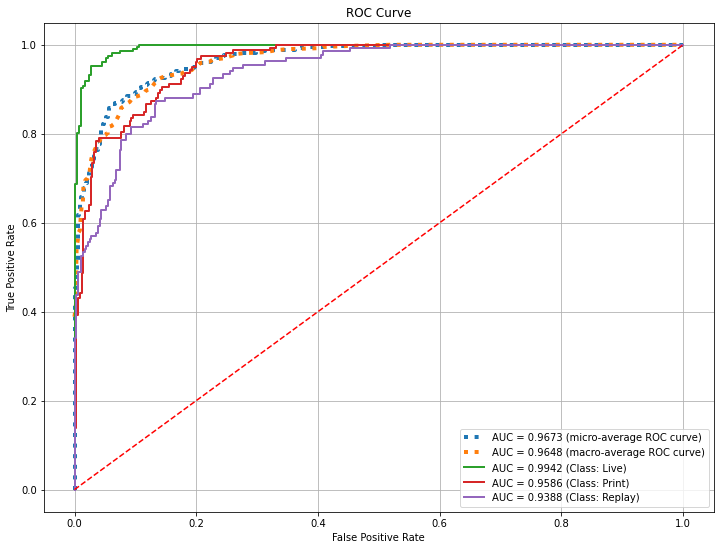

,Accuracy,AUC-ROC,Precision,Recall,F1 score
Live / Print / Replay,0.87,0.963876,0.860637,0.855302,0.856934


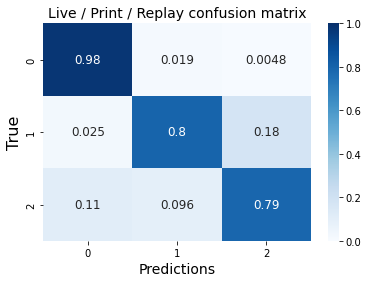

In [4]:

batches, batch_size = 1, 500
cnf_lpr = TestConfig(
    batch_size=batch_size, spoof_categories=[[0],[1,2,3],[7,8,9]],
    model_path='saved_models/AntiSpoofing_print-replay_128.pth')
model = AntiSpoofPredict(cnf_lpr)
loader = get_test_loader(cnf_lpr)
data_iter = iter(loader)
target_all = np.array([])
proba_all = np.empty([0, 3])
pred_all = np.array([])
    
for i in tqdm(range(batches)):
    imgs, target = data_iter.next()
    proba = model.predict(imgs)
    target_all = np.append(target_all, target.numpy())
    pred_all = np.append(pred_all, np.argmax(proba, axis=1))
    proba_all = np.append(proba_all, np.array(proba), axis=0)

res = {'Accuracy' : accuracy_score(target_all, pred_all),
        'AUC-ROC'  : roc_auc_score(target_all, proba_all, multi_class='ovr'),
        'Precision': precision_score(target_all, pred_all, average='macro'),
        'Recall'   : recall_score(target_all, pred_all, average='macro'),
        'F1 score' : f1_score(target_all, pred_all, average='macro')
}
multiclass_roc_curve_plots(target_all, proba_all, class_labels=['Live', 'Print', 'Replay'])

sns.heatmap(pd.DataFrame(confusion_matrix(target_all, pred_all, normalize='true')), 
            annot=True, cmap='Blues', vmin=0, vmax=1, annot_kws={"fontsize":12})
plt.title('Live / Print / Replay confusion matrix', fontsize=14)
plt.xlabel('Predictions', fontsize=14), plt.ylabel('True', fontsize=16)

pd.DataFrame(res, index = ['Live / Print / Replay'])